# Frozen Lake

## Gruppe Baumgartner, Güemes, Schmid

1.   Use Frozen-lake env -> env erklären Marion
2.   Monte Carlo Constant Alpha -> Plots, Auswertung: Marion
3.   Sarsamax -> Simon
3.b  Hyperparameteroptimierung ausprobieren -> Simon (wenn die Zeit reicht...)
3.c  Verschieden Versionen des Env testen (grösse, random, slippery...) -> Simon
4.   Resultate vergleichen (Q-Table und Policy)
5.   On/Off-Policy Erklärung -> Alberto
6.   Model based / Model free Erklärung -> Alberto
7.   Power Point (Google Presentation) erstellen -> Alberto bereitet vor, alle ergänzen


In [3]:
!pip install gym==0.26.0

In [4]:
import gym
from gym.envs.toy_text.frozen_lake import generate_random_map
import random
import numpy as np
from collections import defaultdict, deque
from tqdm import trange # Processing Bar

Helper Function:

In [5]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches


def plot_game_board(map_def_string, ax):
    """
    plot the board of the game given by the map_def_string on the plot ax
    and return the dimesions of the board
    """
    grid_shape = int(np.sqrt(len(map_def_string)))
    custom_map = np.array(list(map_def_string)).reshape(grid_shape, grid_shape)
    new_custom_map = np.full((grid_shape,grid_shape), 1)
    new_custom_map[custom_map == 'F'] = 1
    new_custom_map[custom_map == 'H'] = 0
    new_custom_map[custom_map == 'S'] = 3
    new_custom_map[custom_map == 'G'] = 2

    holes = np.argwhere(new_custom_map == 0 )

    print(custom_map)

    ax.cla()
    ax.imshow(new_custom_map, cmap="Set1")
    ax.grid(True)

    for hole in holes:
        ax.text(hole[1],hole[0], "Hole", ha='center', va='center')

    ax.text(0,0, "Start", ha='center', va='top')
    ax.text(grid_shape-1,grid_shape-1, "Goal", ha='center', va='center')
    return grid_shape

def plot_Q_on_game_board(Q, map_string='SFFFFHFHFFFHHFFG', name="test.png"):
    """
    Plot the Q matrix and its policy for a given frozen-lake game board
    The definition of the boars is given with the map_string.
    For example the 4x4 standart map is:
    map_string='SFFFFHFHFFFHHFFG'
    (this is also the defalt)
    """
    fig, ax = plt.subplots(figsize=(10,10))

    grid_shape = plot_game_board(map_string, ax)

    print(grid_shape)

    for key, values in enumerate(Q):
            if np.sum(values) == 0:
                # don't draw arrows for states with no q-values (end state or holes)
                continue
            posx = key // grid_shape
            posy = key % grid_shape
            action = np.argmax(values)
            # print(f'position- x={posx} y={posy}---; key={key} --;values {values}, action = {action}, value = {values[action]}')
            weight = 'normal'
            if action == 0: # Left
                dx=-1
                dy=0
                ax.text(posy, posx, "L: " + str(round(values[action], 3)), weight=weight,  ha='center', va='center')
            elif action == 1: # Down
                dx=0
                dy=1
                ax.text(posy, posx, "D: " + str(round(values[action], 3)), weight=weight,  ha='center', va='center')
            elif action == 2: # Right
                dx=1
                dy=0
                ax.text(posy, posx, "R: " + str(round(values[action], 3)), weight=weight,  ha='center', va='center')
            elif action == 3: # Up
                dx=0
                dy=-1
                ax.text(posy, posx, "U: " + str(round(values[action], 3)), weight=weight, ha='center', va='center')      
            arrow = mpatches.Arrow(y=posx,x=posy,dx=dx,dy=dy)
            ax.add_patch(arrow)
    fig.show()
    #fig.savefig("./"+name)


In [6]:
def plot_training_performance(avg_scores, n_episodes, plot_every, title, epsilons):
    # plot performance
    plt.plot(np.linspace(0,n_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores), label=f'Average Reward (Over {plot_every} Episodes)')
    if epsilons:
      plt.plot(np.linspace(0,n_episodes,len(epsilons),endpoint=False), np.asarray(epsilons), label='Epsilon')
    plt.xlabel('Episode Number')
    plt.ylabel('Value')
    plt.title(title)
    plt.legend(loc='upper right')
    plt.show()
    ## print best 100-episode performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))    

In [7]:
def create_frozen_lake_env(is_slippery=False, map_def_string="", random_map_size=0, map_name="4x4"):
  """
  Helper method for creating different frozen lake envs
  """
  if random_map_size > 0:
    custom_map = generate_random_map(size=random_map_size)
  elif len(map_def_string) > 0:
    grid_shape = int(np.sqrt(len(map_def_string)))
    custom_map = np.array(list(map_def_string)).reshape(grid_shape, grid_shape)
  else:
    print(f"Creating default {map_name} map, slippery: {is_slippery}")
    return gym.make('FrozenLake-v1', map_name=map_name, is_slippery=is_slippery)
  
  print(f"Creating custom map:\n{custom_map}, slippery: {is_slippery}")
  return gym.make('FrozenLake-v1', desc=custom_map, is_slippery=is_slippery)

In [8]:
# create default 4x4 env
env = create_frozen_lake_env()

print(f'the current space:')
print(f'obs. space:     {env.observation_space}')
print(f'action space:   {env.action_space}')

Creating default 4x4 map, slippery: False
the current space:
obs. space:     Discrete(16)
action space:   Discrete(4)


## Monte Carlo constant $α$

1. Episdodes from Q

In [9]:
from numpy.lib.nanfunctions import nanargmax
def generate_episode(env, Q, epsilon, nActions):
  episode = []
  state = env.reset()[0]
  while True:
    probability = get_probability(Q[state, :], epsilon, nActions)
    action = np.random.choice(np.arange(nActions), p=probability) if state in Q else env.action_space.sample()

    next_state, reward, terminated, truncated, info = env.step(action)

    episode.append((state, action, reward))
    state = next_state
    if terminated or truncated: # ends when falling into the lake or reaching goal
      break
  return episode

def get_probability(Q_s, epsilon, nActions):
  policy_s = np.ones(nActions) * epsilon / nActions
  best_action = np.argmax(Q_s)
  policy_s[best_action] =1 - epsilon + (epsilon/ nActions)
  return policy_s


def update_Q_monte_carlo(env, episode, Q, alpha, gamma):
  states, actions, rewards = zip(*episode)
  discounts = np.array([gamma**i for i in range(len(rewards)+1)])

  for state_idx, state in enumerate(states):
    nr_steps_after_state = len(rewards[state_idx:])
    old_Q = Q[state][actions[state_idx]]
    Q[state][actions[state_idx]] = old_Q + alpha*(sum(rewards[state_idx:]*discounts[:nr_steps_after_state]) - old_Q)
  return Q

In [10]:
import sys

def monte_carlo_control(env, num_episodes, alpha, gamma=1.0, eps_start=1.0, eps_decay=.99999, eps_min=0.05, plot_every=100, exp_name="Montecarlo"):
    n_states, n_actions = env.observation_space.n, env.action_space.n
    Q = np.zeros((n_states, n_actions))
    epsilon = eps_start
    t = trange(num_episodes)

    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)   # average scores over every plot_every episodes
    epsilons = deque(maxlen=num_episodes)

    for i_episode in t:

        epsilon = max(epsilon*eps_decay, eps_min)
        episode = generate_episode(env, Q, epsilon, n_actions)
        Q = update_Q_monte_carlo(env, episode, Q, alpha, gamma)

        # update progress bar
        _, _, rewards = zip(*episode)
        t.set_description(f'Episode {i_episode + 1} Reward {np.max(rewards)} Epsilon {round(epsilon,3)}')
        t.refresh()
        tmp_scores.append(np.max(rewards))
        epsilons.append(epsilon)
        if (i_episode % plot_every == 0):
          avg_scores.append(np.mean(tmp_scores))
    
    plot_training_performance(avg_scores, num_episodes, plot_every, exp_name, epsilons)
    policy = dict((k , np.argmax(v)) for k, v in enumerate(Q))
    return policy, Q

Episode 100000 Reward 0.0 Epsilon 0.05: 100%|██████████| 100000/100000 [09:35<00:00, 173.76it/s]


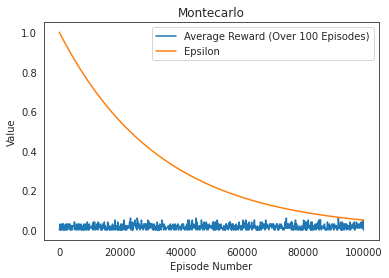

Best Average Reward over 100 Episodes:  0.06


In [ ]:
policy, Q = monte_carlo_control(env, 100_000, 0.02, eps_decay=0.99997)

[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
4


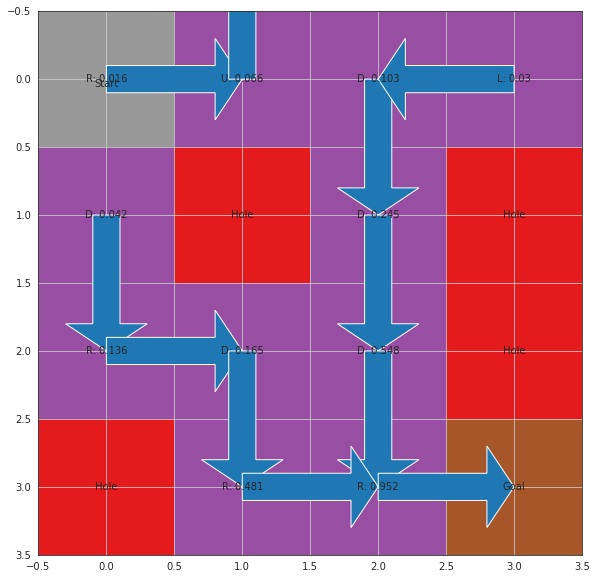

In [ ]:
plot_Q_on_game_board(Q)

In [ ]:
# Create 8x8 map
map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"
env = create_frozen_lake_env(map_def_string=map_def)
policy, Q = monte_carlo_control(env, 100_000, 0.02, eps_decay=0.99997)
plot_Q_on_game_board(Q, map_string=map_def)

## SARSAMAX (Q-Learning)

$Q_{new}(s,a) = Q_{current}(s,a) + α (R + γ Q(s',a') - Q_{current}(s,a))$

- $current = Q_{current}(s,a)$
- $target = R + γ Q(s',a')$
- $Q(s',a') = Q_{next}(s,a)$

$\text{Temporal-Error} = \text{target} - \text {current}$

$lim_{t-> ∞}\text{Temporal-Error} = 0$

In [11]:
# epsilon-greedy exploration strategy
def epsilon_greedy(Q, epsilon, n_actions, s):
    """
    Q: Q Table
    epsilon: exploration parameter
    n_actions: number of actions
    s: state
    """
    # selects a random action with probability epsilon
    if np.random.random() <= epsilon:
        return np.random.randint(n_actions)
    else:
        return np.argmax(Q[s, :])

def get_target_sarsa(Q, reward, gamma, s_, a_ ):
    # value of next state -> "on policy"
    Qsa_next = Q[s_, a_] if s_ is not None else 0  
    target = reward + (gamma * Qsa_next)
    return target

def get_target_sarsamax(Q, reward, gamma, s_, a_ ):
    # "greedy" best value -> "off policy"
    Qsa_next = np.max(Q[s_]) if s_ is not None else 0
    target = reward + (gamma * Qsa_next)
    return target

def q_train(get_target_method, alpha, gamma, epsilon, n_episodes, plot_every=100, exp_name="", eps_decay=0.99999, eps_min=0.05):
    """
    get_target_method: a function which is used to get new target while updating Q-table
    alpha: learning rate
    gamma: exploration parameter
    epsilon: 
    n_episodes: number of episodes
    """
    if len(exp_name) > 0:
      print(f"===== Starting experiment: {exp_name} =====")
      print(f"[alpha:{alpha} gamma:{gamma} epsilon:{epsilon} eps_decay:{eps_decay} eps_min:{eps_min}]")
    
    n_states, n_actions = env.observation_space.n, env.action_space.n

    # initialize Q table
    Q = np.zeros((n_states, n_actions))
    t = trange(n_episodes)
    reward_array = np.zeros(n_episodes)

    # monitor performance
    tmp_scores = deque(maxlen=plot_every)     # deque for keeping track of scores
    avg_scores = deque(maxlen=n_episodes)   # average scores over every plot_every episodes
    epsilons = deque(maxlen=n_episodes)
    
    reached_goal_once = False
    for i in t:
      
        score = 0
        # initial state
        s = env.reset()[0]
        # initial action
        a = epsilon_greedy(Q, epsilon, n_actions, s)

        # epsilon decay
        if reached_goal_once:
          epsilon = max(epsilon*eps_decay, eps_min)

        done = False
        while not done:
            s_, reward, done, _, _ = env.step(a)
            score += reward                                 
            a_ = epsilon_greedy(Q, epsilon, n_actions, s_)
            # update Q table
            target = get_target_method(Q, reward, gamma, s_, a_)
            #Qsa_next = np.max(Q[s_]) if s_ is not None else 0  # value of next state
            Q[s, a] += alpha * (target - Q[s, a])
            if done:
                t.set_description(f'Episode {i + 1} Reward {reward} Epsilon {round(epsilon,3)}')
                t.refresh()
                reward_array[i] = reward
                if not reached_goal_once and reward > 0:
                  reached_goal_once = True
                tmp_scores.append(score)    # append score
                epsilons.append(epsilon)
                break
            s, a = s_, a_
        if (i % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))
    env.close()

    plot_training_performance(avg_scores, n_episodes, plot_every, exp_name, epsilons)
    policy = dict((k , np.argmax(v)) for k, v in enumerate(Q))
    print(f"===== Ending experiment: {exp_name} =====\n")
    return Q, policy, reward_array, avg_scores

Creating default 4x4 map, slippery: False
===== Starting experiment: SARSAMAX Default 4x4 =====
[alpha:0.05 gamma:1.0 epsilon:1.0 eps_decay:0.99997 eps_min:0.05]


Episode 100000 Reward 1.0 Epsilon 0.05: 100%|██████████| 100000/100000 [02:26<00:00, 682.78it/s]


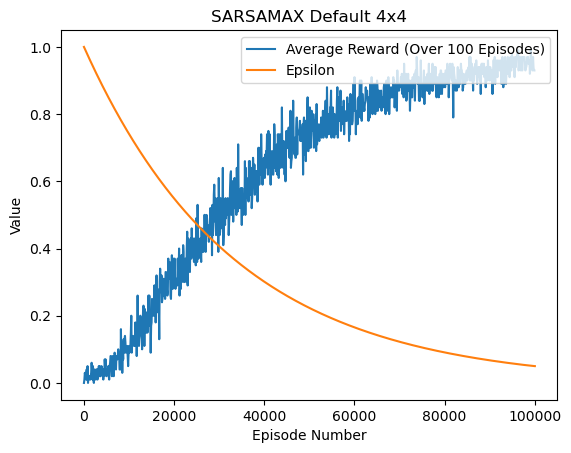

Best Average Reward over 100 Episodes:  0.99
===== Ending experiment: SARSAMAX Default 4x4 =====

[['S' 'F' 'F' 'F']
 ['F' 'H' 'F' 'H']
 ['F' 'F' 'F' 'H']
 ['H' 'F' 'F' 'G']]
4


C:\Users\Simu\AppData\Local\Temp\ipykernel_30608\1501171270.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


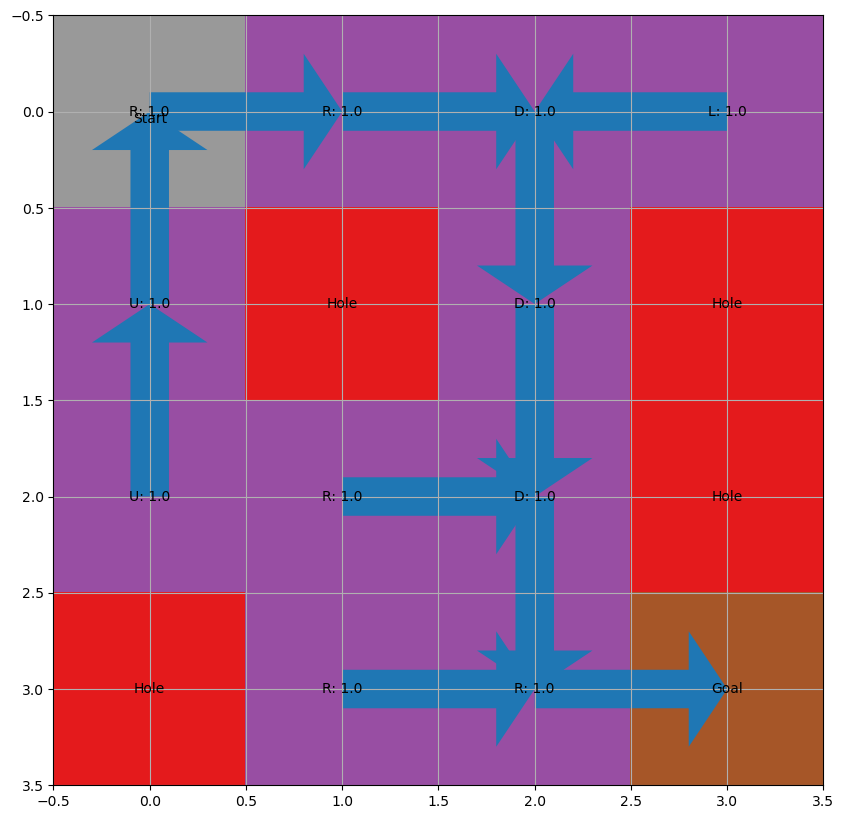

In [13]:
# 4x4 default map
env = create_frozen_lake_env()

# training experiments settings
alpha = 0.05          # learning rate
gamma = 1.0           # discount factor
epsilon = 1.0         # exploration parameter
n_episodes = 100_000  # number of training episodes

Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, eps_decay=0.99997, exp_name="SARSAMAX Default 4x4")
plot_Q_on_game_board(Q)

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: False
===== Starting experiment: SARSAMAX 8x8 =====
[alpha:0.05 gamma:1.0 epsilon:1.0 eps_decay:0.99997 eps_min:0.05]


Episode 100000 Reward 1.0 Epsilon 0.051: 100%|██████████| 100000/100000 [03:10<00:00, 525.87it/s]


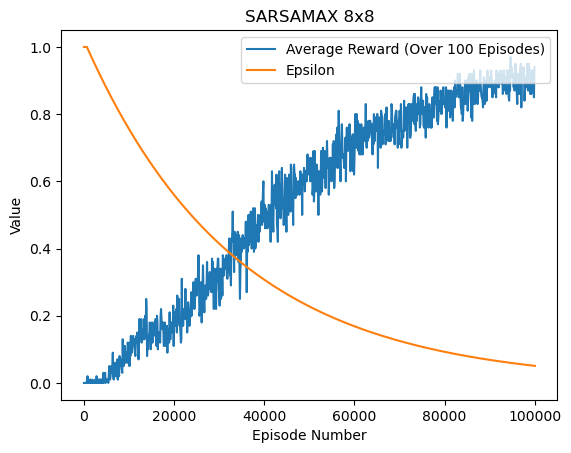

Best Average Reward over 100 Episodes:  0.97
===== Ending experiment: SARSAMAX 8x8 =====

[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']]
8


C:\Users\Simu\AppData\Local\Temp\ipykernel_30608\1501171270.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


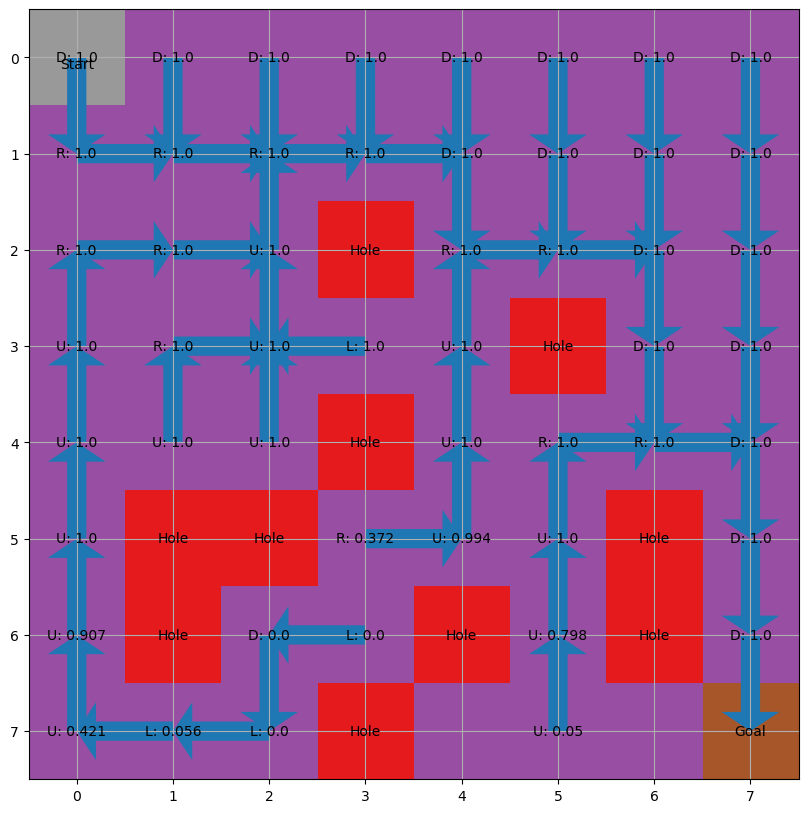

In [14]:
# Create 8x8 map
map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"
env = create_frozen_lake_env(map_def_string=map_def)
Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, eps_decay=0.99997, exp_name="SARSAMAX 8x8")
plot_Q_on_game_board(Q, map_string=map_def)

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: SARSAMAX 8x8 Slippery =====
[alpha:0.05 gamma:1.0 epsilon:1.0 eps_decay:0.99997 eps_min:0.05]


Episode 100000 Reward 0.0 Epsilon 0.05: 100%|██████████| 100000/100000 [09:57<00:00, 167.39it/s]


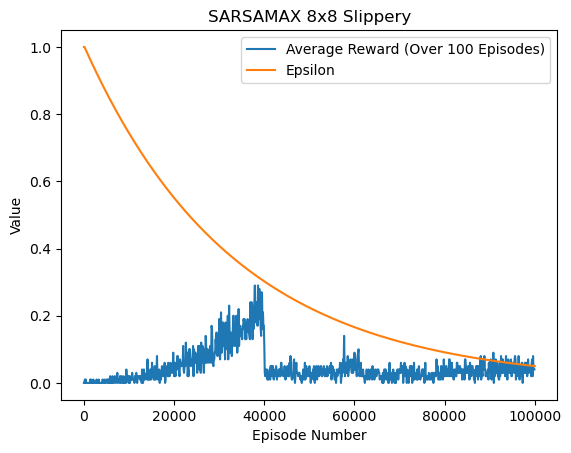

Best Average Reward over 100 Episodes:  0.29
===== Ending experiment: SARSAMAX 8x8 Slippery =====

[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']]
8


C:\Users\Simu\AppData\Local\Temp\ipykernel_30608\1501171270.py:74: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


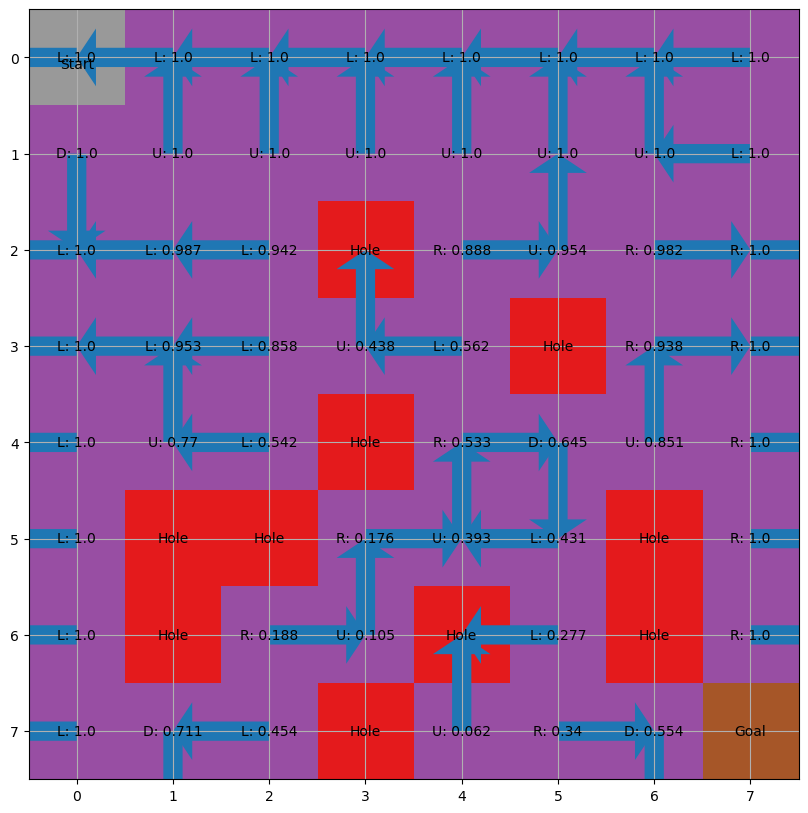

In [15]:
# Create 8x8 slippery map
map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"
env = create_frozen_lake_env(map_def_string=map_def, is_slippery=True)
Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, eps_decay=0.99997, exp_name="SARSAMAX 8x8 Slippery")
plot_Q_on_game_board(Q, map_string=map_def)

## Use optuna for hyperparam-optimization on 8x8 slippery map

In [1]:
!pip install optuna

[I 2022-12-13 09:33:05,092] A new study created in memory with name: no-name-fa6407d8-70f0-44ac-95dc-be86886fced4


Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.3321297445575534 gamma:0.6241669864210694 epsilon:0.9035108929713247 eps_decay:0.9999899812402633 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.552: 100%|██████████| 50000/50000 [01:52<00:00, 444.60it/s]


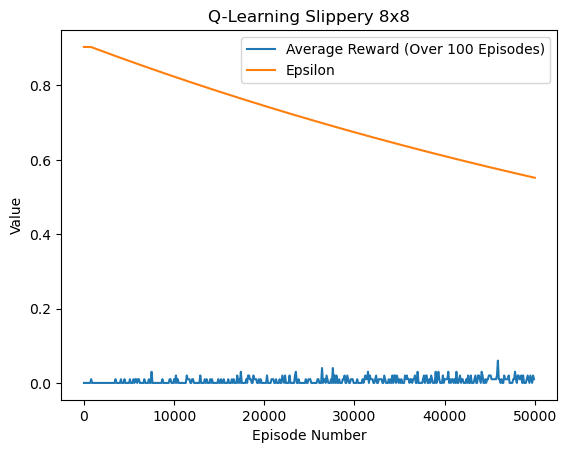

[I 2022-12-13 09:34:57,716] Trial 0 finished with value: 0.06 and parameters: {'alpha': 0.3321297445575534, 'gamma': 0.6241669864210694, 'epsilon': 0.9035108929713247, 'eps_decay': 0.9999899812402633}. Best is trial 0 with value: 0.06.


Best Average Reward over 100 Episodes:  0.06
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.04866875216994573 gamma:0.5957271643225293 epsilon:0.8139169766559018 eps_decay:0.99992464987102 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.05: 100%|██████████| 50000/50000 [01:57<00:00, 424.35it/s] 


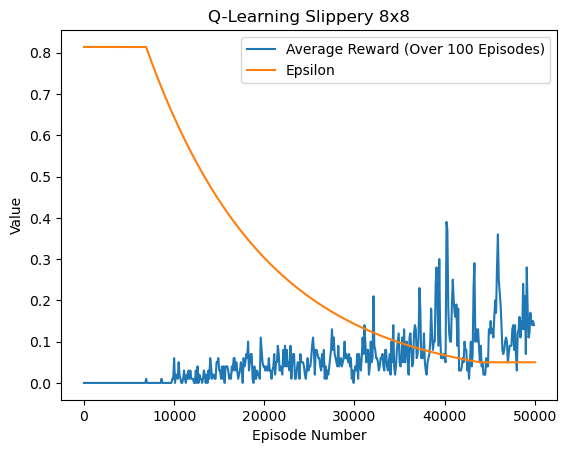

[I 2022-12-13 09:36:55,738] Trial 1 finished with value: 0.39 and parameters: {'alpha': 0.04866875216994573, 'gamma': 0.5957271643225293, 'epsilon': 0.8139169766559018, 'eps_decay': 0.99992464987102}. Best is trial 1 with value: 0.39.


Best Average Reward over 100 Episodes:  0.39
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.2526742384256397 gamma:0.5060699227555984 epsilon:0.8546282371538008 eps_decay:0.999942456974 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [01:51<00:00, 450.05it/s] 


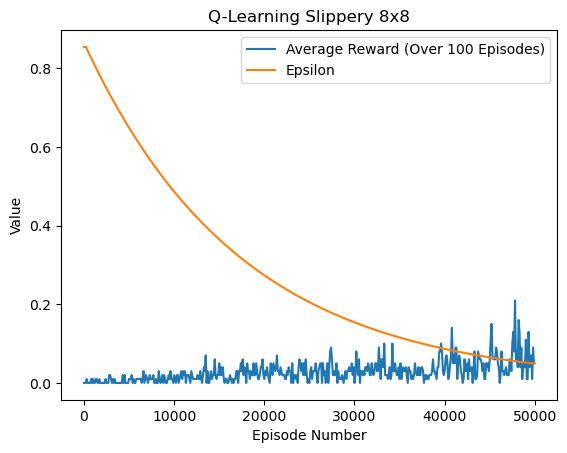

[I 2022-12-13 09:38:47,005] Trial 2 finished with value: 0.21 and parameters: {'alpha': 0.2526742384256397, 'gamma': 0.5060699227555984, 'epsilon': 0.8546282371538008, 'eps_decay': 0.999942456974}. Best is trial 1 with value: 0.39.


Best Average Reward over 100 Episodes:  0.21
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.15633479414294207 gamma:0.9729224924907023 epsilon:0.9117620426235342 eps_decay:0.9999691712728802 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.196: 100%|██████████| 50000/50000 [02:29<00:00, 333.72it/s]


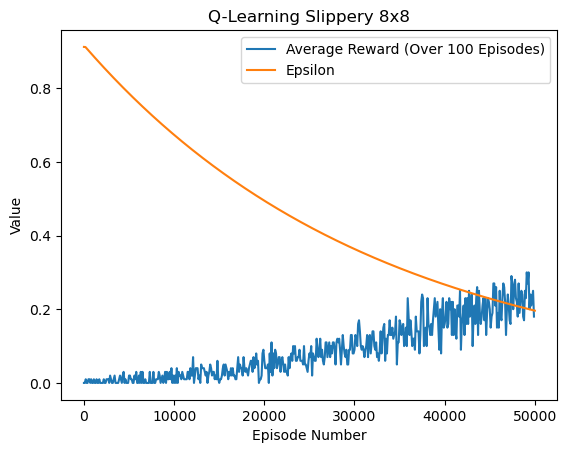

[I 2022-12-13 09:41:17,001] Trial 3 finished with value: 0.3 and parameters: {'alpha': 0.15633479414294207, 'gamma': 0.9729224924907023, 'epsilon': 0.9117620426235342, 'eps_decay': 0.9999691712728802}. Best is trial 1 with value: 0.39.


Best Average Reward over 100 Episodes:  0.3
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.01440332498953623 gamma:0.5859232824309604 epsilon:0.8385764373781183 eps_decay:0.9999514945214358 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.086: 100%|██████████| 50000/50000 [02:00<00:00, 415.83it/s]


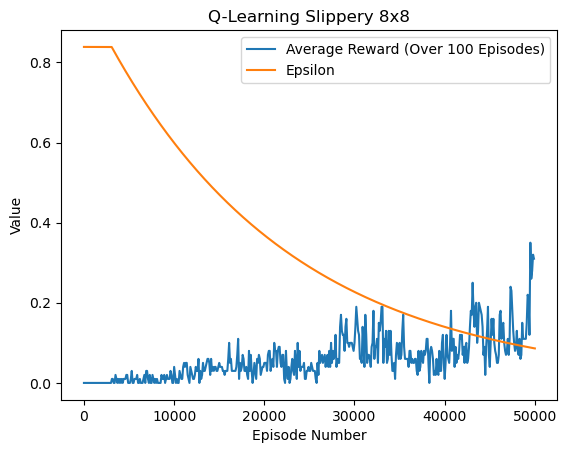

[I 2022-12-13 09:43:17,485] Trial 4 finished with value: 0.35 and parameters: {'alpha': 0.01440332498953623, 'gamma': 0.5859232824309604, 'epsilon': 0.8385764373781183, 'eps_decay': 0.9999514945214358}. Best is trial 1 with value: 0.39.


Best Average Reward over 100 Episodes:  0.35
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.07698084043624233 gamma:0.5222301827626499 epsilon:0.9210429674355373 eps_decay:0.9999167643629563 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [01:50<00:00, 450.73it/s] 


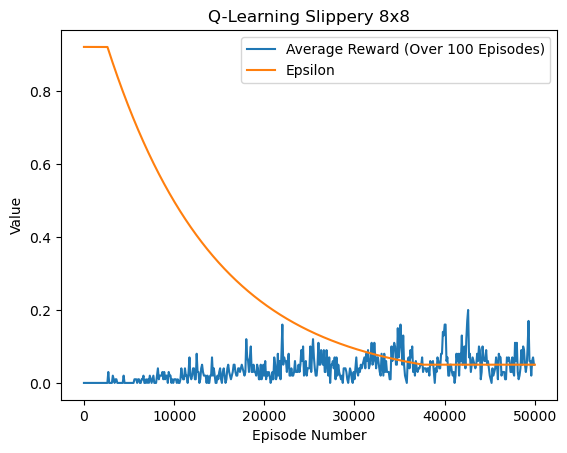

[I 2022-12-13 09:45:08,596] Trial 5 finished with value: 0.2 and parameters: {'alpha': 0.07698084043624233, 'gamma': 0.5222301827626499, 'epsilon': 0.9210429674355373, 'eps_decay': 0.9999167643629563}. Best is trial 1 with value: 0.39.


Best Average Reward over 100 Episodes:  0.2
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.014018397664267542 gamma:0.6273431515968726 epsilon:0.9458873842669896 eps_decay:0.9999303167091628 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:03<00:00, 404.68it/s] 


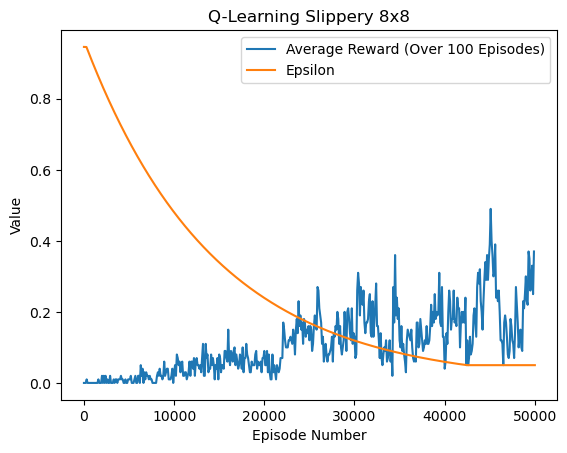

[I 2022-12-13 09:47:12,308] Trial 6 finished with value: 0.49 and parameters: {'alpha': 0.014018397664267542, 'gamma': 0.6273431515968726, 'epsilon': 0.9458873842669896, 'eps_decay': 0.9999303167091628}. Best is trial 6 with value: 0.49.


Best Average Reward over 100 Episodes:  0.49
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.46594005082649104 gamma:0.755915456092874 epsilon:0.9137317811220395 eps_decay:0.9999351606920608 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:09<00:00, 386.84it/s] 


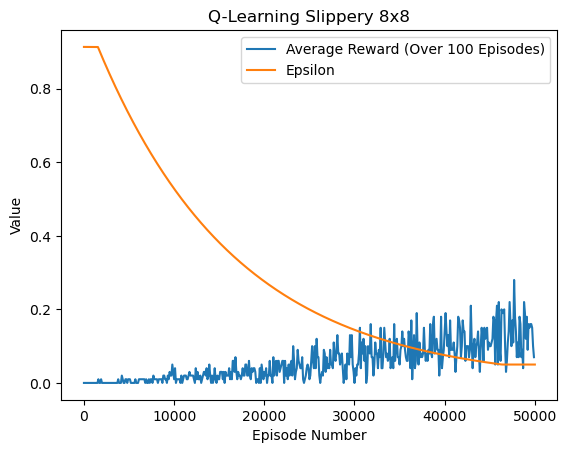

[I 2022-12-13 09:49:21,738] Trial 7 finished with value: 0.28 and parameters: {'alpha': 0.46594005082649104, 'gamma': 0.755915456092874, 'epsilon': 0.9137317811220395, 'eps_decay': 0.9999351606920608}. Best is trial 6 with value: 0.49.


Best Average Reward over 100 Episodes:  0.28
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.056014362911965994 gamma:0.5436044780573299 epsilon:0.8919369541573142 eps_decay:0.9999809216817634 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.352: 100%|██████████| 50000/50000 [01:53<00:00, 440.36it/s]


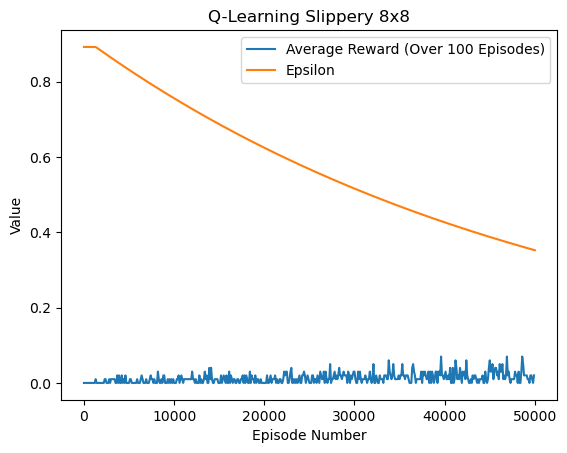

[I 2022-12-13 09:51:15,445] Trial 8 finished with value: 0.07 and parameters: {'alpha': 0.056014362911965994, 'gamma': 0.5436044780573299, 'epsilon': 0.8919369541573142, 'eps_decay': 0.9999809216817634}. Best is trial 6 with value: 0.49.


Best Average Reward over 100 Episodes:  0.07
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.1642786916439222 gamma:0.5186631338691268 epsilon:0.8746759596068496 eps_decay:0.9999239840736326 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [04:04<00:00, 204.33it/s] 


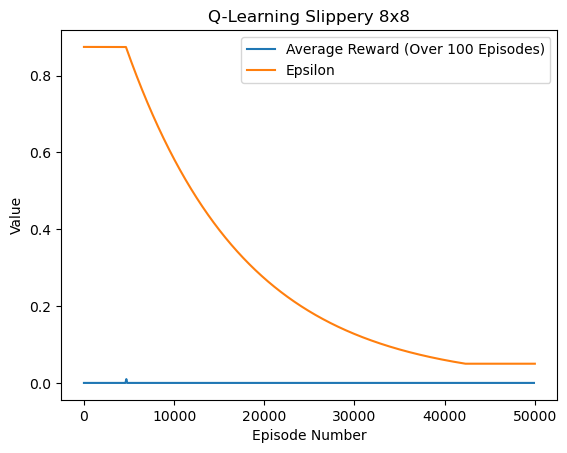

[I 2022-12-13 09:55:20,301] Trial 9 finished with value: 0.01 and parameters: {'alpha': 0.1642786916439222, 'gamma': 0.5186631338691268, 'epsilon': 0.8746759596068496, 'eps_decay': 0.9999239840736326}. Best is trial 6 with value: 0.49.


Best Average Reward over 100 Episodes:  0.01
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.01101230237637155 gamma:0.7356797339649529 epsilon:0.9929338894075281 eps_decay:0.9999019844994298 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:09<00:00, 385.81it/s] 


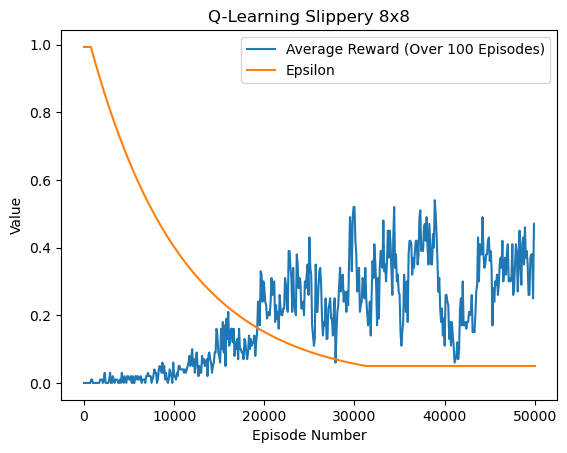

[I 2022-12-13 09:57:30,067] Trial 10 finished with value: 0.54 and parameters: {'alpha': 0.01101230237637155, 'gamma': 0.7356797339649529, 'epsilon': 0.9929338894075281, 'eps_decay': 0.9999019844994298}. Best is trial 10 with value: 0.54.


Best Average Reward over 100 Episodes:  0.54
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.010549034798026982 gamma:0.7535210272854701 epsilon:0.9962064171128756 eps_decay:0.9999018584292617 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:08<00:00, 387.68it/s] 


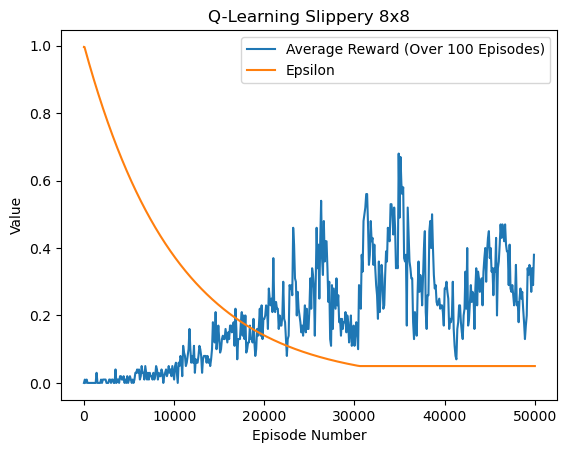

[I 2022-12-13 09:59:39,214] Trial 11 finished with value: 0.68 and parameters: {'alpha': 0.010549034798026982, 'gamma': 0.7535210272854701, 'epsilon': 0.9962064171128756, 'eps_decay': 0.9999018584292617}. Best is trial 11 with value: 0.68.


Best Average Reward over 100 Episodes:  0.68
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.02447844800729948 gamma:0.7700475574523395 epsilon:0.9999792821518579 eps_decay:0.9999000738548486 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:18<00:00, 361.49it/s] 


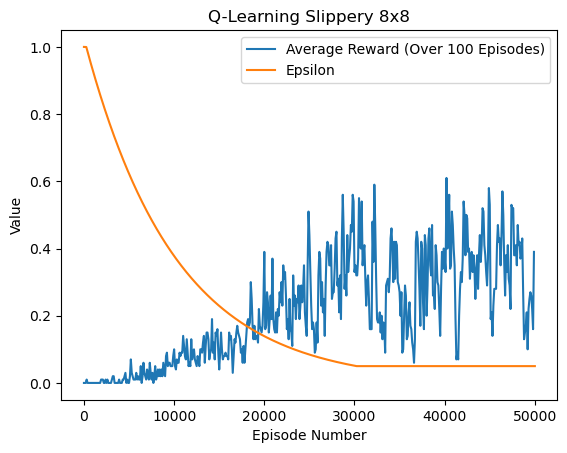

[I 2022-12-13 10:01:57,707] Trial 12 finished with value: 0.61 and parameters: {'alpha': 0.02447844800729948, 'gamma': 0.7700475574523395, 'epsilon': 0.9999792821518579, 'eps_decay': 0.9999000738548486}. Best is trial 11 with value: 0.68.


Best Average Reward over 100 Episodes:  0.61
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.02676294859930445 gamma:0.862167950153792 epsilon:0.9990071279482211 eps_decay:0.9999045525080212 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:29<00:00, 333.44it/s] 


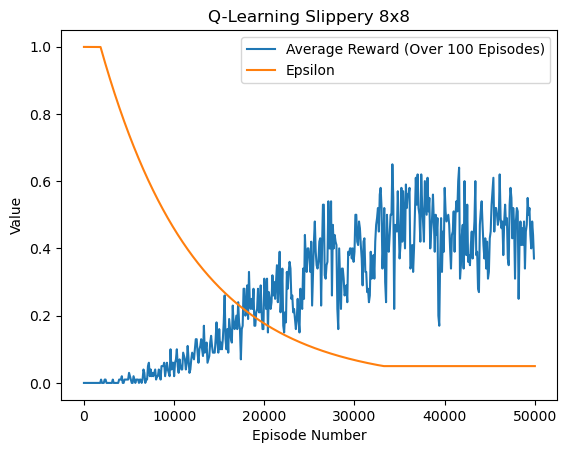

[I 2022-12-13 10:04:27,832] Trial 13 finished with value: 0.65 and parameters: {'alpha': 0.02676294859930445, 'gamma': 0.862167950153792, 'epsilon': 0.9990071279482211, 'eps_decay': 0.9999045525080212}. Best is trial 11 with value: 0.68.


Best Average Reward over 100 Episodes:  0.65
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.027527529204307382 gamma:0.8901109110347798 epsilon:0.9663847430302609 eps_decay:0.9999115218149784 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:29<00:00, 334.96it/s] 


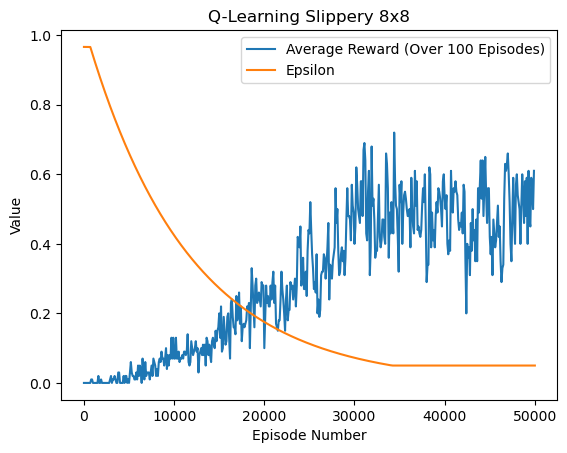

[I 2022-12-13 10:06:57,288] Trial 14 finished with value: 0.72 and parameters: {'alpha': 0.027527529204307382, 'gamma': 0.8901109110347798, 'epsilon': 0.9663847430302609, 'eps_decay': 0.9999115218149784}. Best is trial 14 with value: 0.72.


Best Average Reward over 100 Episodes:  0.72
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.025382711135641632 gamma:0.848129819072221 epsilon:0.961512659196558 eps_decay:0.999914820097258 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:31<00:00, 330.55it/s] 


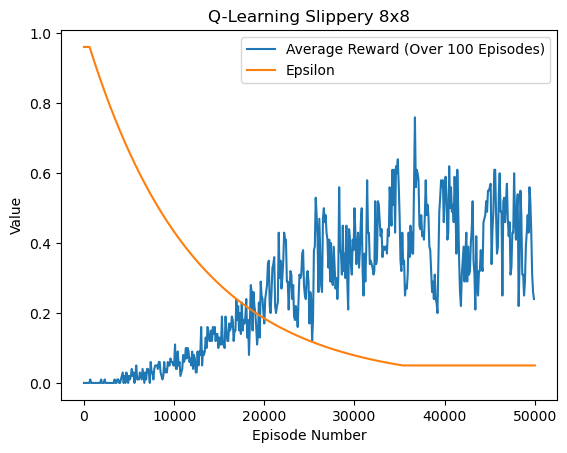

[I 2022-12-13 10:09:28,728] Trial 15 finished with value: 0.76 and parameters: {'alpha': 0.025382711135641632, 'gamma': 0.848129819072221, 'epsilon': 0.961512659196558, 'eps_decay': 0.999914820097258}. Best is trial 15 with value: 0.76.


Best Average Reward over 100 Episodes:  0.76
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.030128140081899988 gamma:0.8620634672097424 epsilon:0.9629822194187583 eps_decay:0.9999165656160983 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:28<00:00, 336.64it/s] 


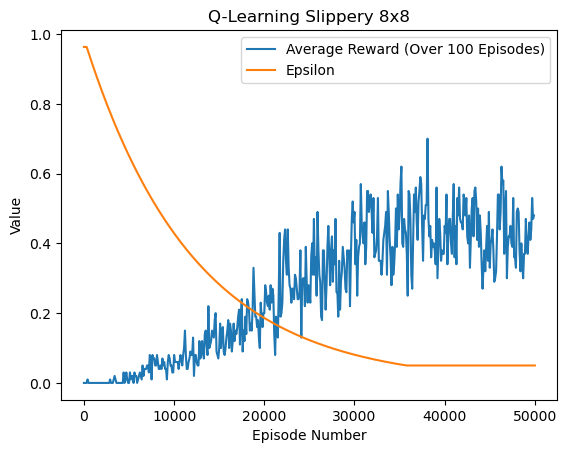

[I 2022-12-13 10:11:57,428] Trial 16 finished with value: 0.7 and parameters: {'alpha': 0.030128140081899988, 'gamma': 0.8620634672097424, 'epsilon': 0.9629822194187583, 'eps_decay': 0.9999165656160983}. Best is trial 15 with value: 0.76.


Best Average Reward over 100 Episodes:  0.7
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.03953913037587761 gamma:0.9878835377236528 epsilon:0.9536659049301115 eps_decay:0.9999540516976646 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.098: 100%|██████████| 50000/50000 [02:43<00:00, 305.08it/s]


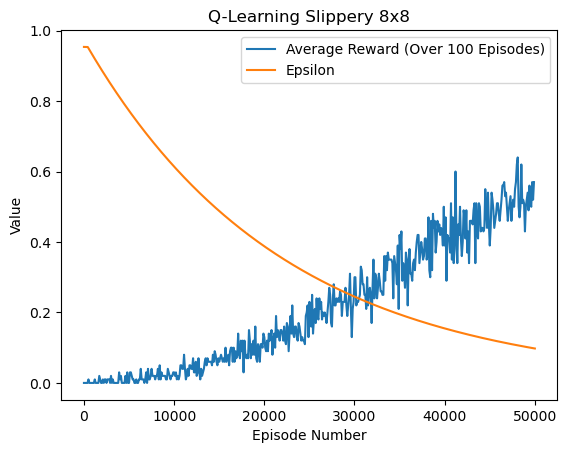

[I 2022-12-13 10:14:41,514] Trial 17 finished with value: 0.64 and parameters: {'alpha': 0.03953913037587761, 'gamma': 0.9878835377236528, 'epsilon': 0.9536659049301115, 'eps_decay': 0.9999540516976646}. Best is trial 15 with value: 0.76.


Best Average Reward over 100 Episodes:  0.64
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.09813532182446226 gamma:0.8675063153393586 epsilon:0.9385728789432891 eps_decay:0.9999133716310791 eps_min:0.05]


Episode 50000 Reward 0.0 Epsilon 0.05: 100%|██████████| 50000/50000 [02:25<00:00, 343.91it/s] 


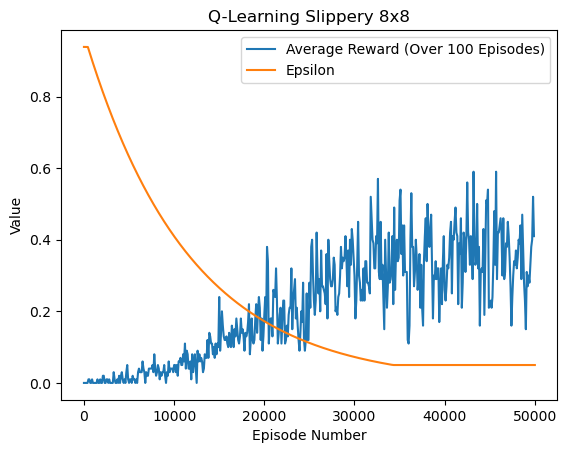

[I 2022-12-13 10:17:07,073] Trial 18 finished with value: 0.59 and parameters: {'alpha': 0.09813532182446226, 'gamma': 0.8675063153393586, 'epsilon': 0.9385728789432891, 'eps_decay': 0.9999133716310791}. Best is trial 15 with value: 0.76.


Best Average Reward over 100 Episodes:  0.59
===== Ending experiment: Q-Learning Slippery 8x8 =====

Creating custom map:
[['S' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'F' 'F' 'F' 'F' 'H' 'F' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'F']
 ['F' 'H' 'H' 'F' 'F' 'F' 'H' 'F']
 ['F' 'H' 'F' 'F' 'H' 'F' 'H' 'F']
 ['F' 'F' 'F' 'H' 'F' 'F' 'F' 'G']], slippery: True
===== Starting experiment: Q-Learning Slippery 8x8 =====
[alpha:0.018188765365606527 gamma:0.8153152164188757 epsilon:0.9661002152906848 eps_decay:0.9999408615897474 eps_min:0.05]


Episode 50000 Reward 1.0 Epsilon 0.053: 100%|██████████| 50000/50000 [02:18<00:00, 360.95it/s]


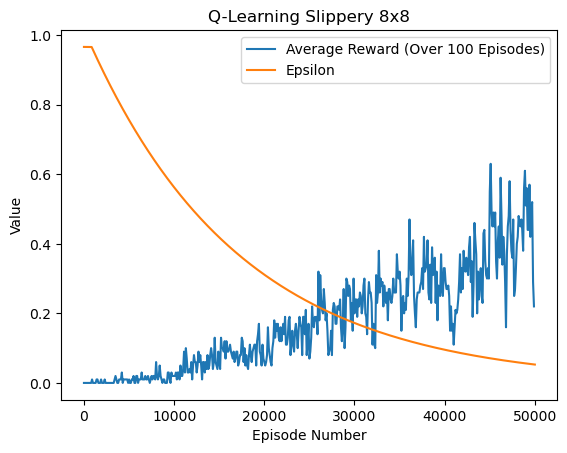

[I 2022-12-13 10:19:25,762] Trial 19 finished with value: 0.63 and parameters: {'alpha': 0.018188765365606527, 'gamma': 0.8153152164188757, 'epsilon': 0.9661002152906848, 'eps_decay': 0.9999408615897474}. Best is trial 15 with value: 0.76.


Best Average Reward over 100 Episodes:  0.63
===== Ending experiment: Q-Learning Slippery 8x8 =====

Accuracy: 0.76
Best hyperparameters: {'alpha': 0.025382711135641632, 'gamma': 0.848129819072221, 'epsilon': 0.961512659196558, 'eps_decay': 0.999914820097258}


In [16]:
import optuna

map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"

def objective(trial):
    # training experiments settings
    alpha = 0.05          # learning rate
    gamma = 1.0           # discount factor
    epsilon = 1.0         # exploration parameter
    n_episodes = 50_000  # number of training episodes

    # 8x8 Slippery
    env = create_frozen_lake_env(map_def_string=map_def, is_slippery=True)

    alpha = trial.suggest_float('alpha', 0.01, 0.5, log=True) # learning rate
    gamma = trial.suggest_float('gamma', 0.5, 1.0, log=True)    # starting discount factor
    epsilon = trial.suggest_float('epsilon', 0.8, 1.0, log=True)  # exploration parameter
    eps_decay = trial.suggest_float('eps_decay', 0.9999, 0.99999, log=True)  # decay rate of epsilon

    #Q, policy, reward_array, avg_scores = q_train(get_target_sarsa, alpha, gamma, epsilon, n_episodes, exp_name="SARSA Default 4x4")
    Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, exp_name="Q-Learning Slippery 8x8", eps_decay=eps_decay)
    
    return np.max(avg_scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

trial = study.best_trial

print('Accuracy: {}'.format(trial.value))
print("Best hyperparameters: {}".format(trial.params))

In [ ]:
# Best result of optimization, stretched to 100_000 episodes 
# Create 8x8 slippery map
map_def = "SFFFFFFFFFFFFFFFFFFHFFFFFFFFFHFFFFFHFFFFFHHFFFHFFHFFHFHFFFFHFFFG"
env = create_frozen_lake_env(map_def_string=map_def, is_slippery=True)
n_episodes = 100_000
alpha = 0.016
gamma = 0.9958
epsilon = 0.875
eps_decay = 0.999943
Q, policy, reward_array, avg_scores = q_train(get_target_sarsamax, alpha, gamma, epsilon, n_episodes, eps_decay=eps_decay, exp_name="SARSAMAX 8x8 Slippery - Best")
plot_Q_on_game_board(Q, map_string=map_def)